In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

in_path = "Restaurant reviews.csv"
out_path = "/content/restaurant_reviews_cleaned.csv"

df = pd.read_csv(in_path)

# Drop unnamed columns
df = df.drop(columns=[c for c in df.columns if c.strip().lower().startswith("unnamed") or c.strip() == "7514"],
             errors="ignore")

# Drop empty reviews
df["Review"] = df["Review"].astype(str).str.strip()
df = df[df["Review"].notna() & (df["Review"] != "") & (df["Review"].str.lower() != "nan")].copy()

# Drop non-numeric ratings
df["Rating_num"] = pd.to_numeric(df["Rating"], errors="coerce")
df = df[df["Rating_num"].notna()].copy()

# Remove timestamp and reviewer name
df = df.drop(columns=[c for c in ["Time", "Reviewer"] if c in df.columns], errors="ignore")

# Convert rating to sentiment
def rating_to_sentiment(r):
    if r < 3.0:
        return "negative"
    elif r == 3.0:
        return "neutral"
    else:
        return "positive"

df["Sentiment"] = df["Rating_num"].apply(rating_to_sentiment)

# Cleaning text
stopwords = set(ENGLISH_STOP_WORDS)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = [w for w in text.split() if w not in stopwords]
    return " ".join(tokens)

# Apply text cleaning function to all reviews
df["Review_clean"] = df["Review"].apply(clean_text)

# Save the cleaned and labeled dataset to a CSV file
df.to_csv(out_path, index=False)

print("Cleaned dataset saved to:", out_path)
print("Rows remaining:", len(df))

Cleaned dataset saved to: /content/restaurant_reviews_cleaned.csv
Rows remaining: 9954


In [ ]:
#step 2: feature representation

#load cleaned dataset produced in step 1
df = pd.read_csv("/content/restaurant_reviews_cleaned.csv")

#inspect basic structure
df.head()

,Restaurant,Review,Rating,Metadata,Pictures,Rating_num,Sentiment,Review_clean
0,Beyond Flavours,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",0,5.0,positive,ambience good food quite good saturday lunch c...
1,Beyond Flavours,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",0,5.0,positive,ambience good pleasant evening service prompt ...
2,Beyond Flavours,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",0,5.0,positive,try great food great ambience thnx service pra...
3,Beyond Flavours,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",0,5.0,positive,soumen das arun great guy behavior sincerety g...
4,Beyond Flavours,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",0,5.0,positive,food good ordered kodi drumsticks basket mutto...


In [ ]:
#define feature text and target labels
X_text = df["Review_clean"]
y = df["Sentiment"]

#check
print("Number of reviews:", len(X_text))
print("\nSentiment distribution:")
print(y.value_counts())

Number of reviews: 9954

Sentiment distribution:
Sentiment
positive    6315
negative    2447
neutral     1192
Name: count, dtype: int64


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#initialize TF-IDF vectorizer with fixed feature settings
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 1),   #unigrams only
    max_features=5000,    #fixed vocabulary size
    min_df=2,             #ignore very rare words
    max_df=0.95           #ignore overly common words
)

In [ ]:
#check for invalid cleaned reviews
print("NaNs in Review_clean:", df["Review_clean"].isna().sum())
print("Empty strings in Review_clean:", (df["Review_clean"] == "").sum())


NaNs in Review_clean: 21
Empty strings in Review_clean: 0


In [ ]:
#drop rows with NaN cleaned text
df = df[df["Review_clean"].notna()].copy()

#redefine features and labels after dropping rows
X_text = df["Review_clean"]
y = df["Sentiment"]

print("Rows remaining after dropping invalid reviews:", len(df))


Rows remaining after dropping invalid reviews: 9933


In [ ]:
#fit TF-IDF on cleaned, valid review text
X_tfidf = tfidf_vectorizer.fit_transform(X_text)

print("TF-IDF matrix shape:", X_tfidf.shape)


TF-IDF matrix shape: (9933, 5000)


Step 3: Modeling Methodology

In [ ]:
# step3: train-test split
# Splits the data into training and held-out test sets while preserving sentiment class proportions

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,               # Feature matrix
    y,                     # Sentiment labels
    test_size=0.2,         # Use 20% of the data for testing
    random_state=42,       # Ensures reproducibility of the script
    stratify=y             # Preserves class proportions across train and test sets
)

# Print the number of samples in each split
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

# Verify that sentiment class distribution is preserved in the training set
print("\nTraining sentiment distribution:")
print(y_train.value_counts())

Training set size: 7946
Test set size: 1987

Training sentiment distribution:
Sentiment
positive    5040
negative    1954
neutral      952
Name: count, dtype: int64


In [ ]:
# step 3: Baseline Model - Naive Bayes

from sklearn.naive_bayes import MultinomialNB

# Initialize the Multinomial Naive Bayes model
nb_model = MultinomialNB()
# Fit (train) the model using the training data
# The model learns the relationship between TF-IDF features
# and sentiment labels.
nb_model.fit(X_train, y_train)

print("Naive Bayes model trained.")

Naive Bayes model trained.


In [ ]:
# Step 3: Baseline model - Logistic Regression with class weighting

from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
# - class_weight="balanced" automatically adjusts weights inversely
#   proportional to class frequencies to reduce bias toward majority classes
# - max_iter=1000 increases the number of iterations to ensure convergence
#   on high-dimensional TF-IDF feature space
# - solver="lbfgs" is a robust optimizer suitable for multinomial
#   and large-scale datasets

lr_model = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    solver="lbfgs"
)
# Fit (train) the model using the training data
# The model learns linear decision boundaries that separate
# sentiment classes based on TF-IDF features.

lr_model.fit(X_train, y_train)

print("Logistic Regression model trained with class weighting.")

Logistic Regression model trained with class weighting.


In [ ]:
# Step 3: Validate model training by confirming that each classifier learned non-empty parameters and could successfully generate
# predictions

# # Print model objects to verify initialization and fitted state
print(nb_model)
print(lr_model)

## Naive Bayes Parameter Checks
print("Naive Bayes class count shape:", nb_model.class_count_.shape)
print("Naive Bayes feature log prob shape:", nb_model.feature_log_prob_.shape)

## Logistic Regression Parameter Checks
print("Logistic Regression coefficient shape:", lr_model.coef_.shape)
print("Logistic Regression intercept shape:", lr_model.intercept_.shape)

## Checking that both models are able to generate predictions accurately.
sample_review = X_test[0]
print("Naive Bayes prediction:", nb_model.predict(sample_review))
print("Logistic Regression prediction:", lr_model.predict(sample_review))

MultinomialNB()
LogisticRegression(class_weight='balanced', max_iter=1000)
Naive Bayes class count shape: (3,)
Naive Bayes feature log prob shape: (3, 5000)
Logistic Regression coefficient shape: (3, 5000)
Logistic Regression intercept shape: (3,)
Naive Bayes prediction: ['positive']
Logistic Regression prediction: ['positive']


In [ ]:
# Step 3: Generate Predictions
nb_preds = nb_model.predict(X_test)
lr_preds = lr_model.predict(X_test)

print("Predictions generated for both models.")

Predictions generated for both models.


In [ ]:
# Step 4: Model Accuracy

import numpy as np

# # Compute Naive Bayes accuracy as the proportion of correct predictions
nb_accuracy = np.mean(nb_preds == y_test)
print("NB Accuracy:", nb_accuracy)

# Identify indices where Naive Bayes predictions do not match true labels
# This allows for later error analysis or inspection of misclassified samples
nb_mismatches = np.where(nb_preds != y_test)[0]
print("Number of NB mismatches:", len(nb_mismatches))

# Compute Logistic Regression accuracy as the proportion of correct predictions
lr_accuracy = np.mean(lr_preds == y_test)
print("LR Accuracy:", lr_accuracy)

# Identify indices where Logistic Regression predictions do not match true labels
lr_mismatches = np.where(lr_preds != y_test)[0]
print("Number of LR mismatches:", len(lr_mismatches))

NB Accuracy: 0.7916456970306995
Number of NB mismatches: 414
LR Accuracy: 0.782083543029693
Number of LR mismatches: 433


Naive Bayes confusion matrix:


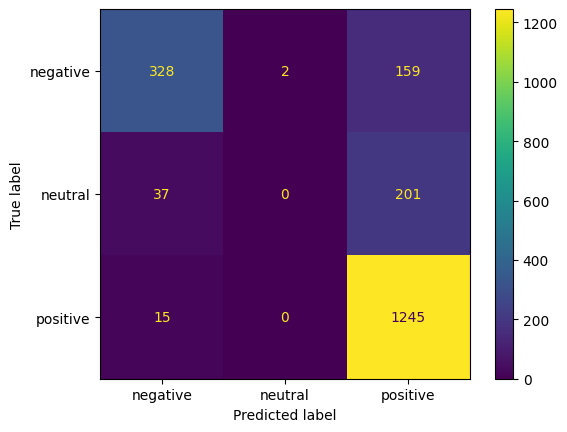

Logistic Regression confusion matrix:


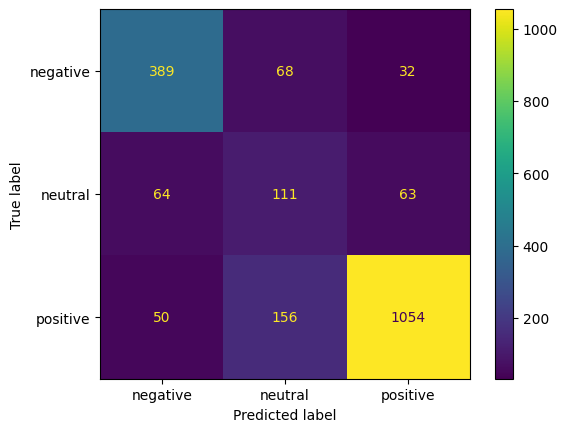

In [ ]:
# Step 4: Confusion Matrices

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# --- Naive Bayes Confusion Matrix ---
# Displays counts of true positives, true negatives, false positives,
# and false negatives for the Naive Bayes classifier
print("Naive Bayes confusion matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, nb_preds)
plt.show()

# --- Logistic Regression Confusion Matrix ---
# Allows direct comparison with Naive Bayes to identify which model
# better distinguishes between sentiment classes
print("Logistic Regression confusion matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, lr_preds)
plt.show()

In [ ]:
# Step 4: Classification Reports
from sklearn.metrics import classification_report

# --- Naive Bayes Classification Report ---
# Shows how well the Naive Bayes model performs for each sentiment class,
# highlighting trade-offs between precision and recall.
print("NB classification report")
print(classification_report(y_test, nb_preds))

# --- Logistic Regression Classification Report ---
# Enables comparison with Naive Bayes to assess which model better
# balances precision and recall, especially for minority classes.
print("LR classification report")
print(classification_report(y_test, lr_preds))

NB classification report
              precision    recall  f1-score   support

    negative       0.86      0.67      0.75       489
     neutral       0.00      0.00      0.00       238
    positive       0.78      0.99      0.87      1260

    accuracy                           0.79      1987
   macro avg       0.55      0.55      0.54      1987
weighted avg       0.70      0.79      0.74      1987

LR classification report
              precision    recall  f1-score   support

    negative       0.77      0.80      0.78       489
     neutral       0.33      0.47      0.39       238
    positive       0.92      0.84      0.88      1260

    accuracy                           0.78      1987
   macro avg       0.67      0.70      0.68      1987
weighted avg       0.81      0.78      0.79      1987



In [ ]:
# Save the DataFrame to a CSV file
df.to_csv(out_path, index=False)

# Download the CSV file to the local machine (Google Colab environment only)
from google.colab import files
files.download(out_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>